## Informações sobre o modelo desenvolvido:

**Desenvolvimento de um modelo de classificador composto por uma rede CNN pré-treinada  e uma rede densa MLP (Perceptron Multi-Camadas).**

Etapas da metodologia aplicada: 
1.   Entrada de imagens
2.   Pré-processamento (redução de dimensão de imagem e aplicação de greyscale)
3.   Balanceamento
4.   Divisão treino/teste
5.   Seleção de dados
6.   Treinamento
7.   Validação
8.   Resultado final


Para simplificar a implementação do modelo, foi decidido classificar as lesões entre maligno e benigno, sendo que a partir das 7 classes de lesões foram criadas duas meta classes para o classificador.

Foi feito um Binary Downsampling para equalizar a quantidade de imagens de lesões benignas e malignas, pois a quantidade de dados para benignas era mais de duas vezes maior que a outra classe.

As imagens do dataset original tiveram a dimensão reduzida e foi aplicada uma escala de preto e branco.

it was transfer the learning of a ResNet-50 trained with Imagenet to a model that identify images from HAM10000 dataset and classifies whether a lesion is malignant or benign

# Setup

In [2]:
# Mount Drive
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/Trabalho\ Sistemas\ de\ Inteligencia/ root

Mounted at /content/gdrive


In [3]:
# manipulação de dataset
import pandas as pd

# pacote de álgebra linear, faz manipulações de vetores e etc
import numpy as np

# import pytorch as pyt
from PIL import Image, ImageOps

# functions for creating and removing a directory (folder), fetching its contents, changing and identifying the current directory, etc
import os

# used to return all file paths that match a specific pattern
import glob

# opencv-python, solve computer vision problems
import cv2

# functions to compare files and directories, with various optional time/correctness trade-offs
import filecmp

# split dataset between training and testing data
from sklearn.model_selection import train_test_split

# preprocessing and Normalization, includes scaling, centering, normalization, binarization methods.
from sklearn import preprocessing

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.applications import ResNet50

import seaborn as sns

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from google.colab.patches import cv2_imshow

# Leitura do dataset não processado

In [4]:
groundTruthPath = 'root/GroundTruth.csv'

In [5]:
originalDataset = pd.read_csv(groundTruthPath)
originalDataset.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


**Transforma onehot encoder em labels qualitativos**

Onehot encoder é uma técnica que transforma valores qualitativos em quantitativos através da geração de conjuntos R^(numero de classes)

In [6]:

labels=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
label_list=[]

detailedDataset = originalDataset.copy()

for i in range (len(originalDataset)):
    row = list(originalDataset.iloc[i])
    del row[0]
    index = np.argmax(row)
    label = labels[index]
    label_list.append(label)
    
detailedDataset['label'] = label_list
detailedDataset = detailedDataset.drop(labels, axis=1)
detailedDataset.head()

,image,label
0,ISIC_0024306,NV
1,ISIC_0024307,NV
2,ISIC_0024308,NV
3,ISIC_0024309,NV
4,ISIC_0024310,MEL


# Amostragem dos dados do dataset com as 7 classes de lesões

NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: label, dtype: int64


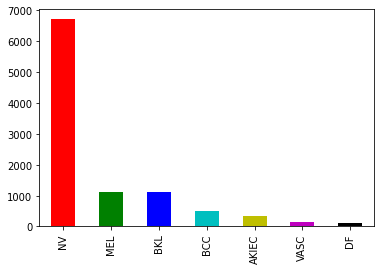

In [7]:
detailedDataset['label'].value_counts().plot.bar(color=['r','g','b','c','y','m','k'])
print(detailedDataset['label'].value_counts())

# Divisão do dataset em meta-classes: benignos e malignos

Estratégia inicial para verificar o resultado do modelo com balancea,emto por subamostragem (downsampling) entre as duas meta-classes


In [8]:
benignLesions = ['NV', 'BKL', 'DF', 'VASC']
malignLesions = ['MEL', 'BCC', 'AKIEC']
benignCode = 'Benigno'
malignCode = 'Maligno'

simplifiedDataset = detailedDataset.copy()

def classifyLesions(row):
  if row['label'] in benignLesions:
    return benignCode
  return malignCode

simplifiedDataset['type'] = simplifiedDataset.apply (lambda row: classifyLesions(row), axis=1)
simplifiedDataset = simplifiedDataset.drop('label', axis=1)
simplifiedDataset.head()

,image,type
0,ISIC_0024306,Benigno
1,ISIC_0024307,Benigno
2,ISIC_0024308,Benigno
3,ISIC_0024309,Benigno
4,ISIC_0024310,Maligno


# Balanceamento

A importância do balanceamento está na etapa de treinamento, entretando ele é realizado com a base inteira antes do treino e teste para não enviesar conjuntos de dados.

Ao optar por fazer o resample antes do split, faz com que o conjunto seja mais próximo de uma base de dados balanceada normal já que foi optado pelo downsampling. 

Foi escolhido fazer o resample de todo o conjunto de dados antes do split para evitar ter que averiguar se a distribuição do conjunto de treinamento se manteve a mesma do dataset para não enviesar o modelo com a reamostragem erroneamente.

Dado que o balanceamento será realizado antes do split, os dados de teste 

Importante deixar cada classe com a quantidade de imagens mais parecida possível.

Nessa abordagem inicial mais simples, queremos somente dividir o data set em duas classes e deixar a mesma quantidade de imagens para cada classe.


In [9]:
print('original number of classes: ', len(detailedDataset['label'].unique()))     

original number of classes:  7


Benigno    8061
Maligno    1954
Name: type, dtype: int64



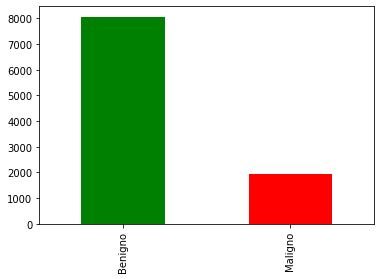

In [10]:
simplifiedDataset['type'].value_counts().plot.bar(color=['g','r'])
print(simplifiedDataset['type'].value_counts())
print()

In [11]:
df = simplifiedDataset;
print(df)

              image     type
0      ISIC_0024306  Benigno
1      ISIC_0024307  Benigno
2      ISIC_0024308  Benigno
3      ISIC_0024309  Benigno
4      ISIC_0024310  Maligno
...             ...      ...
10010  ISIC_0034316  Maligno
10011  ISIC_0034317  Maligno
10012  ISIC_0034318  Benigno
10013  ISIC_0034319  Benigno
10014  ISIC_0034320  Benigno

[10015 rows x 2 columns]


dataset is highly out of balance limit maximum samples per class to 1954 (balanceamento por baixo) samples to help balance it

In [12]:
#size = 1954 # set number of samples for each class
size= 1954 # set number of samples for each class
samples = []

group=df.groupby('type')

for label in df['type'].unique():
    Lgroup=group.get_group(label)
    count=int(Lgroup['type'].value_counts())    
    if count>=size:
        sample=Lgroup.sample(size, axis=0)        
    else:        
        sample=Lgroup.sample(frac=1, axis=0)
    samples.append(sample) 

balanced_df = pd.concat(samples, axis=0).reset_index(drop=True)

print(len(balanced_df))
print('final number of classes: ', len(balanced_df['type'].unique()))       
print(balanced_df['type'].value_counts())  

3908
final number of classes:  2
Benigno    1954
Maligno    1954
Name: type, dtype: int64


# Aplicação de LabelEncoder(type)

Etapa executada antes da divisão de conjuntos para evitar custo computacional ao ter que verificar se os dois conjuntos estão se refereindo a meta classe da mesma forma.

Transformação de:
> Benigno->0

> Maligno-> 1

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [13]:
balanced_df.head()

,image,type
0,ISIC_0030684,Benigno
1,ISIC_0031831,Benigno
2,ISIC_0024406,Benigno
3,ISIC_0029945,Benigno
4,ISIC_0024603,Benigno


In [14]:
le = preprocessing.LabelEncoder()
balanced_df['type']=le.fit_transform(balanced_df['type'])
balanced_df.head()

,image,type
0,ISIC_0030684,0
1,ISIC_0031831,0
2,ISIC_0024406,0
3,ISIC_0029945,0
4,ISIC_0024603,0


# Train Test Split

Essa divisão do dataset está sendo feita após a etapa de balanceamento para prevenir bias (viéses) no treinamento que venham a resultar em um modelo com tendêncidas não generalizadas.
O objetivo do modelo é ser o mais geral possível

- Teste será feito com 20% do dataset já balanceado
- Treinamento será feito com 80% do dataset já balanceado

In [15]:
test_size = .20 # set this to the percent of the data you want to use for validation
train_size = .80 # set this to the percentof the data you want to use for training

split_df = balanced_df.copy()
train_df, test_df = train_test_split(split_df, test_size = test_size, train_size = train_size, random_state=42, shuffle=True)

In [16]:
print(len(test_df))
test_df.head()

782


,image,type
1896,ISIC_0033075,0
2802,ISIC_0029995,1
1962,ISIC_0025097,1
2104,ISIC_0033662,1
1539,ISIC_0026263,0


In [17]:
print(len(train_df))
train_df.head()

3126


,image,type
247,ISIC_0027854,0
2957,ISIC_0032030,1
2622,ISIC_0027793,1
2335,ISIC_0028807,1
2775,ISIC_0029915,1


In [18]:
for data in train_df['image']:
  print(data+'.jpg')

ISIC_0027854.jpg
ISIC_0032030.jpg
ISIC_0027793.jpg
ISIC_0028807.jpg
ISIC_0029915.jpg
ISIC_0028963.jpg
ISIC_0030636.jpg
ISIC_0027315.jpg
ISIC_0029044.jpg
ISIC_0030794.jpg
ISIC_0025709.jpg
ISIC_0028882.jpg
ISIC_0025774.jpg
ISIC_0028106.jpg
ISIC_0026128.jpg
ISIC_0026232.jpg
ISIC_0025128.jpg
ISIC_0031335.jpg
ISIC_0028617.jpg
ISIC_0026112.jpg
ISIC_0031430.jpg
ISIC_0030299.jpg
ISIC_0031929.jpg
ISIC_0027428.jpg
ISIC_0028049.jpg
ISIC_0031570.jpg
ISIC_0028170.jpg
ISIC_0029781.jpg
ISIC_0030770.jpg
ISIC_0030716.jpg
ISIC_0029555.jpg
ISIC_0027896.jpg
ISIC_0026934.jpg
ISIC_0024779.jpg
ISIC_0030803.jpg
ISIC_0031842.jpg
ISIC_0027624.jpg
ISIC_0024443.jpg
ISIC_0026933.jpg
ISIC_0033569.jpg
ISIC_0033595.jpg
ISIC_0029192.jpg
ISIC_0030027.jpg
ISIC_0026149.jpg
ISIC_0026124.jpg
ISIC_0031941.jpg
ISIC_0033429.jpg
ISIC_0033694.jpg
ISIC_0028088.jpg
ISIC_0026831.jpg
ISIC_0029332.jpg
ISIC_0030417.jpg
ISIC_0032954.jpg
ISIC_0025492.jpg
ISIC_0034142.jpg
ISIC_0027836.jpg
ISIC_0025149.jpg
ISIC_0024382.jpg
ISIC_0033905.j

# Obter as imagens do dataset

In [19]:
PATH_PROCESSED_CONST = 'root/images/reshape-150_200/'

all_files = glob.glob(os.path.join(PATH_PROCESSED_CONST, "*.jpg"))
print(all_files[1])

root/images/reshape-150_200/ISIC_0031741.jpg


Aplicar greyscale e reshape nas imagens

In [20]:
print(train_df['image'])

print(type(train_df['image']))

247     ISIC_0027854
2957    ISIC_0032030
2622    ISIC_0027793
2335    ISIC_0028807
2775    ISIC_0029915
            ...     
1130    ISIC_0034153
1294    ISIC_0031694
860     ISIC_0026880
3507    ISIC_0024575
3174    ISIC_0027595
Name: image, Length: 3126, dtype: object
<class 'pandas.core.series.Series'>


In [21]:
X_train = []
y_train =[]
X_test = []
y_test =[]
for img_name, img_type in zip(train_df['image'],train_df['type'] ):
  img = cv2.imread(PATH_PROCESSED_CONST + str(img_name)+'.jpg')
  img =np.asarray(img).astype('float32')
  if not (np.isnan(img).any()):
    X_train.append(img)
    y_train.append(img_type)

for img_name, img_type in zip(test_df['image'],test_df['type']):
  img = cv2.imread(PATH_PROCESSED_CONST + str(img_name)+'.jpg')
  img =np.asarray(img).astype('float32')
  if not (np.isnan(img).any()):
    X_test.append(img)
    y_test.append(img_type)

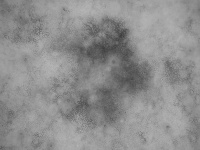

In [22]:
cv2_imshow(X_test[0])

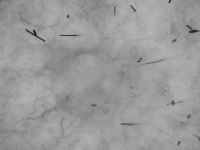

In [23]:
cv2_imshow(X_train[0])

In [24]:
X_train[0].shape

(150, 200, 3)

# Criar modelo

**goal**: transfer the learning of a ResNet-50 trained with Imagenet to a model that identify images from HAM10000 dataset.

- Construir uma rede neural CNN (tipo de modelo deep learning) levando em conta a dimensão das imagens com resize

- Utilização de CNN através da rede ResNet-50

**Convolutional Neural Network (CNN):** arquitetura de rede
- Arquitetura de rede neural com presença de camadas convolucionais, responsáveis por identificar padrões do dado de entrada, funcionando como um extrator de características inteligentes.
- Por ser uma arquitetura taxada como pesada, é comum a utilização de TL - utilização de um modelo base que é adaptado para a nova tarefa em questão, congelando os pesos de algumas camadas do modelo, necessitando o treinamento de apenas uma parcela das camadas do modelo final, reduzindo o custo computacional do modelo.

**Transfer Learning (TL):** metodologia de aprendizado
- Adapta um modelo base previamente treinado como forma de reduzir o processo de treinamento do modelo proposto
- use a model that has been trained on large scale data for our problem.
- Commonly used Transfer Learning Models: Inception, Xception, VGG Family, ResNet

**Deep Residual Networks (ResNet, ResNet50):** modelo específico de CNN
- specific type of convolutional neural network (CNN)
- is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer)
- Residual neural networks are a type of artificial neural network (ANN) that forms networks by stacking residual blocks.
- ResNet has supervised learning

https://www.tensorflow.org/tutorials/images/cnn

https://analyticsindiamag.com/a-comparison-of-4-popular-transfer-learning-models/

https://keras.io/api/applications/resnet/

Based on article: https://towardsdatascience.com/transfer-learning-for-image-classification-using-tensorflow-71c359b56673


In [25]:
resized_height = 150 # image height
resized_width = 200   # image width
resized_channels = 3  # number of color channels, RGB

In [26]:
# Initialize the Pretrained Model
feature_extractor = ResNet50(weights='imagenet', 
                             input_shape=(resized_height, resized_width, resized_channels),
                             include_top=False)

# Set this parameter to make sure it's not being trained
feature_extractor.trainable = False

# Set the input layer
input_ = tf.keras.Input(shape=(resized_height, resized_width, resized_channels))

# Set the feature extractor layer
x = feature_extractor(input_, training=False)

# Set the pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Set Flatten Layer
x= tf.keras.layers.Flatten()(x)

# Set Dense Layers
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(2048, activation='relu',
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.008))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu',
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.008))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation='relu',
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.008))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu',
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.008))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(100, activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.001))(x)

# Importante se atentar a quanto podemos reduzir o L2 de modo a ainda subir o treinamento e a validação
# O L2 dificulta aumentar a precisão, a accuracy do modelo, é necessário fazer um balanço para não causar overfitting e ter uma boa performance

# Set the final layer with sigmoid activation function
output_ = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the new model object
model = tf.keras.Model(input_, output_)

# Compile it
model.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

# Print The Summary of The Model
model.summary()


94765736/94765736 [==============================] - 7s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 200, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352

Problemas com overfitting foram resolvidos com regularization:

https://towardsdatascience.com/machine-learning-model-regularization-in-practice-an-example-with-keras-and-tensorflow-2-0-52a96746123e

https://www.kaggle.com/general/226433

Learning rate na loss:

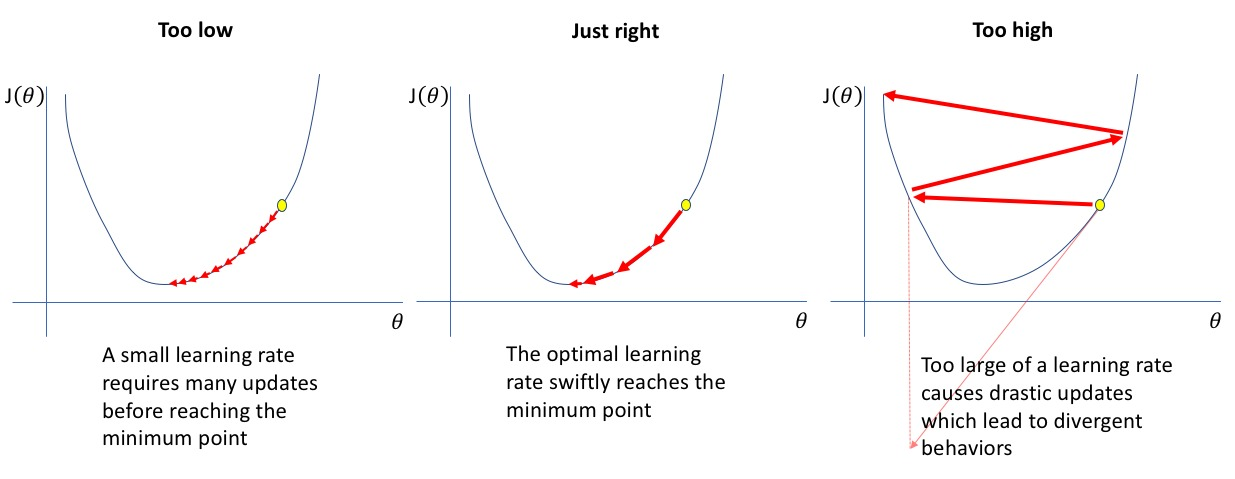

- se a loss ficar variando muito, reduz o learning rate
- se a los andar muito lento, aumenta o learning rate

Overfitting:

não se da pelos dois acc estarem diferentes, e sim estarem divergindo (enquanto um sobe, o outro desce por exemplo)

se forem diferentes mas crescerem, é underfitting, deixa treinar

In [27]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [28]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.20)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


58/58 [==============================] - 17s 111ms/step - loss: 32.6895 - accuracy: 0.6307 - val_loss: 18.9936 - val_accuracy: 0.6957
Epoch 2/100
58/58 [==============================] - 5s 86ms/step - loss: 13.5547 - accuracy: 0.6759 - val_loss: 9.4913 - val_accuracy: 0.6957
Epoch 3/100
58/58 [==============================] - 5s 85ms/step - loss: 7.3964 - accuracy: 0.6781 - val_loss: 5.6378 - val_accuracy: 0.6957
Epoch 4/100
58/58 [==============================] - 5s 85ms/step - loss: 4.5968 - accuracy: 0.6786 - val_loss: 3.6809 - val_accuracy: 0.6957
Epoch 5/100
58/58 [==============================] - 5s 85ms/step - loss: 3.1208 - accuracy: 0.6792 - val_loss: 2.6066 - val_accuracy: 0.6957
Epoch 6/100
58/58 [==============================] - 5s 86ms/step - loss: 2.2879 - accuracy: 0.6792 - val_loss: 1.9795 - val_accuracy: 0.6957
Epoch 7/100
58/58 [==============================] - 5s 86ms/step - loss: 1.8007 - accuracy: 0.6792 - val_loss: 1.6040 - val_accuracy: 0.6957
Epoch 8/100
5

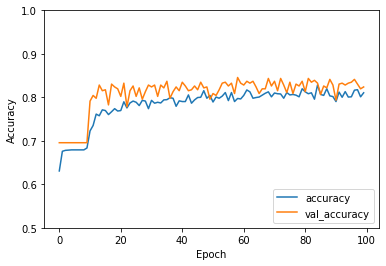

In [29]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [30]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(test_acc)

18/18 - 2s - loss: 0.5329 - accuracy: 0.8060 - 2s/epoch - 109ms/step
0.8059964776039124


18/18 [==============================] - 3s 76ms/step


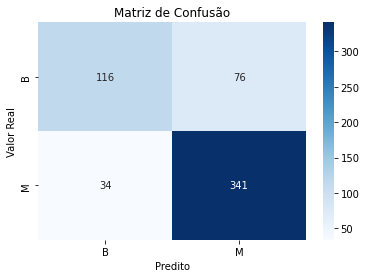

In [31]:
y_pred = model.predict(X_test)
y_p = np.where(y_pred > 0.5, 1, 0)
y_true = y_test
cm = confusion_matrix(y_true, y_p)
ax = sns.heatmap(cm, annot=True, fmt='', cmap='Blues')          

plt.xlabel('Predito')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão')
ax.set_xticklabels('BM')
ax.set_yticklabels('BM')
plt.show()

In [32]:
target_names = ['benigno', 'maligno']

# 0 = benigno, 1 = maligno

print(classification_report(y_true, y_p, target_names=target_names))

              precision    recall  f1-score   support

     benigno       0.77      0.60      0.68       192
     maligno       0.82      0.91      0.86       375

    accuracy                           0.81       567
   macro avg       0.80      0.76      0.77       567
weighted avg       0.80      0.81      0.80       567



**Conclusão sobre os resultados:**

- Tivemos bastante problemas com overfitting, apesar dos resultados para a métrica de falso negativo alcançaram um bom número, mas ao aplicar regularization os problemas foram resolvidos.
- recall acima de 90% pra tumores malignos e no geral a acc em 80%, que é o que definimos como a métrica mais importante devido ao contexto de saúde
- Uma possibilidade de melhora do modelo desenvolvido é aplicar data augmentation (aplicar filtro de cor nas imagens para verificar se alguma facilita na extração de características do classificador, girar imagens para formar outras, etc) nos dados antes da divisão em dados de treino e teste para termos mais dados válidos.
- Outra possibilidade de melhoria é implementar um metaclassificador e verificar se os resultados melhoram.